In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from matplotlib.ticker import FormatStrFormatter

In [2]:
# Dataset downloaded from 
d = pd.read_csv('H:/Desktop\\US_Chronic_Disease_Indicators_CDI.csv', low_memory=False)

In [43]:
questions_units = d.loc[d.TopicID=="ALC"][["Question", "DataValueUnit", "DataValueType", "Data"]].drop_duplicates()
questions_units.to_csv("H:/Desktop/question_units.csv")

In [120]:
# Alcohol consumption data, 2014
consum = d.loc[d['Question']=="Per capita alcohol consumption among persons aged >= 14 years"].loc[d['YearEnd']==2014]
consum = consum.loc[consum['DataValueAlt'].dropna().index].sort_values('DataValueAlt', ascending=False)

# Alcohol - heavy drinking data, 2014
heav = d.loc[d['Question']=="Heavy drinking among adults aged >= 18 years"].loc[d['YearEnd']==2014]\
    .loc[d['DataValueType']=="Age-adjusted Prevalence"].loc[d['Stratification1']=="Overall"]
heav = heav.loc[heav['DataValueAlt'].dropna().index]


locabbr = pd.Series(np.intersect1d(consum["LocationAbbr"].values,heav["LocationAbbr"].values))
consum = consum.loc[consum["LocationAbbr"].isin(locabbr)]
heav = heav.loc[heav["LocationAbbr"].isin(locabbr)]

In [172]:
# Binge drinking, age-adjusted mean, overall population, Year end 2014
binge = d.loc[d["Question"]=="Binge drinking prevalence among adults aged >= 18 years"].loc[d["YearEnd"]==2014]\
    .loc[d["DataValueTypeID"]=="AGEADJPREV"].loc[d["StratificationCategoryID1"]=="OVERALL"]
binge = binge.loc[binge["DataValueAlt"].dropna().index]

# Alcohol use among youth, year end 2015
yth = d.loc[d["Question"]=="Alcohol use among youth"].loc[d["YearEnd"]==2015]
yth = yth.loc[yth["DataValueAlt"].dropna().index]

# Chronic liver disease mortality, overall stratification, age-adjusted rate, 2014
chron = d.loc[d["Question"]=="Chronic liver disease mortality"].loc[d["YearEnd"]==2014]\
    .loc[d["StratificationCategory1"]=="Overall"].loc[d["DataValueType"]=="Age-adjusted Rate"]
chron = chron.loc[chron["DataValueAlt"].dropna().index].sort_values("DataValueAlt", ascending=False)

In [173]:
flds = ["Question","LocationAbbr", "DataValueAlt"]
dsets = {"con_ld":{"name": "con_ld", "df": consum, "ax_label": "Per Capita Alcohol Consumption (gallons)"},
         "heav_ld": {"name": "heav_ld", "df": heav, "ax_label": "% of Adults Who Drink Heavily (age-adjusted)"},
         "bng_ld": {"name":"bng_ld", "df": binge, "ax_label": "% of Adults Who Binge Drink (age-adjusted)"},
         "yth_ld": {"name": "yth_ld", "df": yth, "ax_label": "% of Youth Who Consume Alcohol (crude)"}}

chrond = {"df": chron, "ax_label": "Chronic Liver Disease Mortality (cases per 100K, age adjusted)"}
# dsets["fig_ds"] = dsets["df"].map(lambda x: pd.merge(chron[flds], x[flds], on="LocationAbbr"))
# # ErrorType unhashable type: 'list'

# dsets = [x.get("fig_ds", pd.merge(chron[flds], x["df"][flds], on="LocationAbbr")) for x in dsets]
# # TypeError: unhashable type: 'list'

In [174]:
con_ld = pd.merge(chrond["df"][flds], dsets["con_ld"]["df"][flds], on="LocationAbbr")
heav_ld = pd.merge(chrond["df"][flds], dsets["heav_ld"]["df"][flds], on="LocationAbbr")
bng_ld = pd.merge(chrond["df"][flds], dsets["bng_ld"]["df"][flds], on="LocationAbbr")
yth_ld = pd.merge(chrond["df"][flds], dsets["yth_ld"]["df"][flds], on="LocationAbbr")

In [273]:
auth = d.loc[d["Question"]=="Local authority to regulate alcohol outlet density"].copy()
auth = auth.loc[auth["YearEnd"]==2014]
auth.loc[auth["DataValue"].isna(), ["DataValue"]] = "Category 7 - No regulation authority"
auth = auth[["DataValue", "Topic"]].groupby("DataValue").count()
auth["Category"] = auth.index
auth["labels"] = list(map(lambda x, y: '{} (n={})'.format(x, y), auth["Category"], auth["Topic"]))

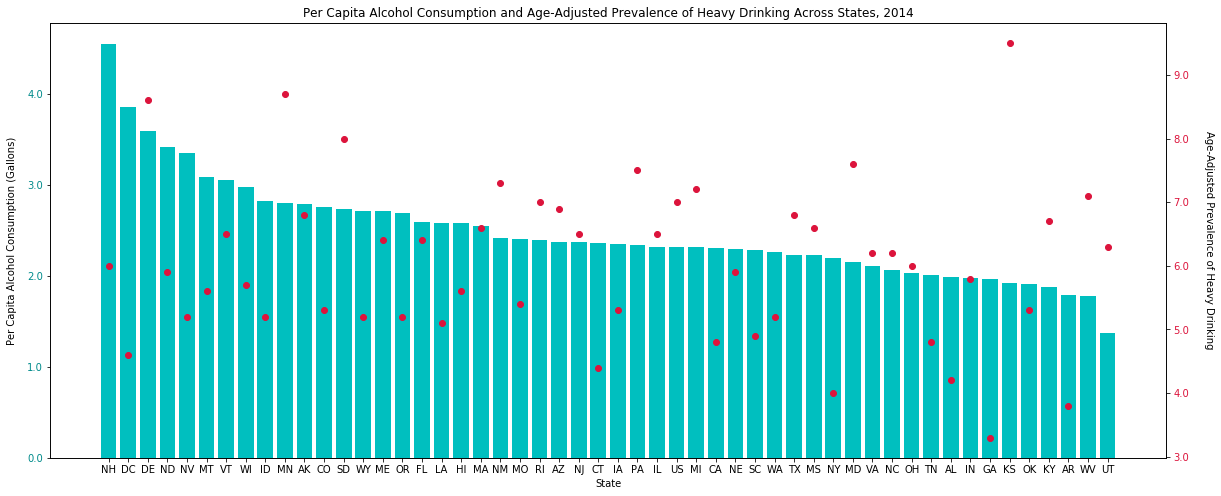

In [223]:
%matplotlib inline
plt.figure(figsize=(20,8))

consum_x = "Per Capita Alcohol Consumption (Gallons)"
pca = plt.subplot()
pca.set_xlabel("State")
pca.set_ylabel(consum_x, labelpad=10)
pca.tick_params(axis='y', labelcolor='darkcyan')
pca.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
pca.set_title("Per Capita Alcohol Consumption and Age-Adjusted Prevalence of Heavy Drinking Across States, 2014")
pca.bar(consum['LocationAbbr'], consum['DataValueAlt'], color='c')

heav_x = "Age-Adjusted Prevalence of Heavy Drinking"
hv = pca.twinx()
hv.set_ylabel(heav_x, labelpad=25).set_rotation(-90)
hv.tick_params(axis='y', labelcolor='crimson')
hv.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
hv.scatter(heav['LocationAbbr'], heav['DataValueAlt'], color='crimson')
plt.xticks(list(range(len(consum.index))), consum.LocationAbbr)
plt.show()

## Overall and Heavy Alcohol Consumption Patterns in the United States, 2014

This analysis comes from the CDC's Indicators for Chronic Disease Surveillance, which compiles data from multiple data sources across a range of chronic disease and other wellness topics. This analysis focuses on alcohol consumption. In this first graph, I wanted to explore whether there was any correlation between states that had overall high alcohol consumption (measured in gallons per capita over the entire year), and prevelance of heavy drinking. I expected that states with higher overall consumption would also have a higher prevalence of heavy drinking. In fact, the figure suggests little or no correlation in any direction. One possible explanation is that the number of heavy drinkers across states is far less than moderate drinkers.

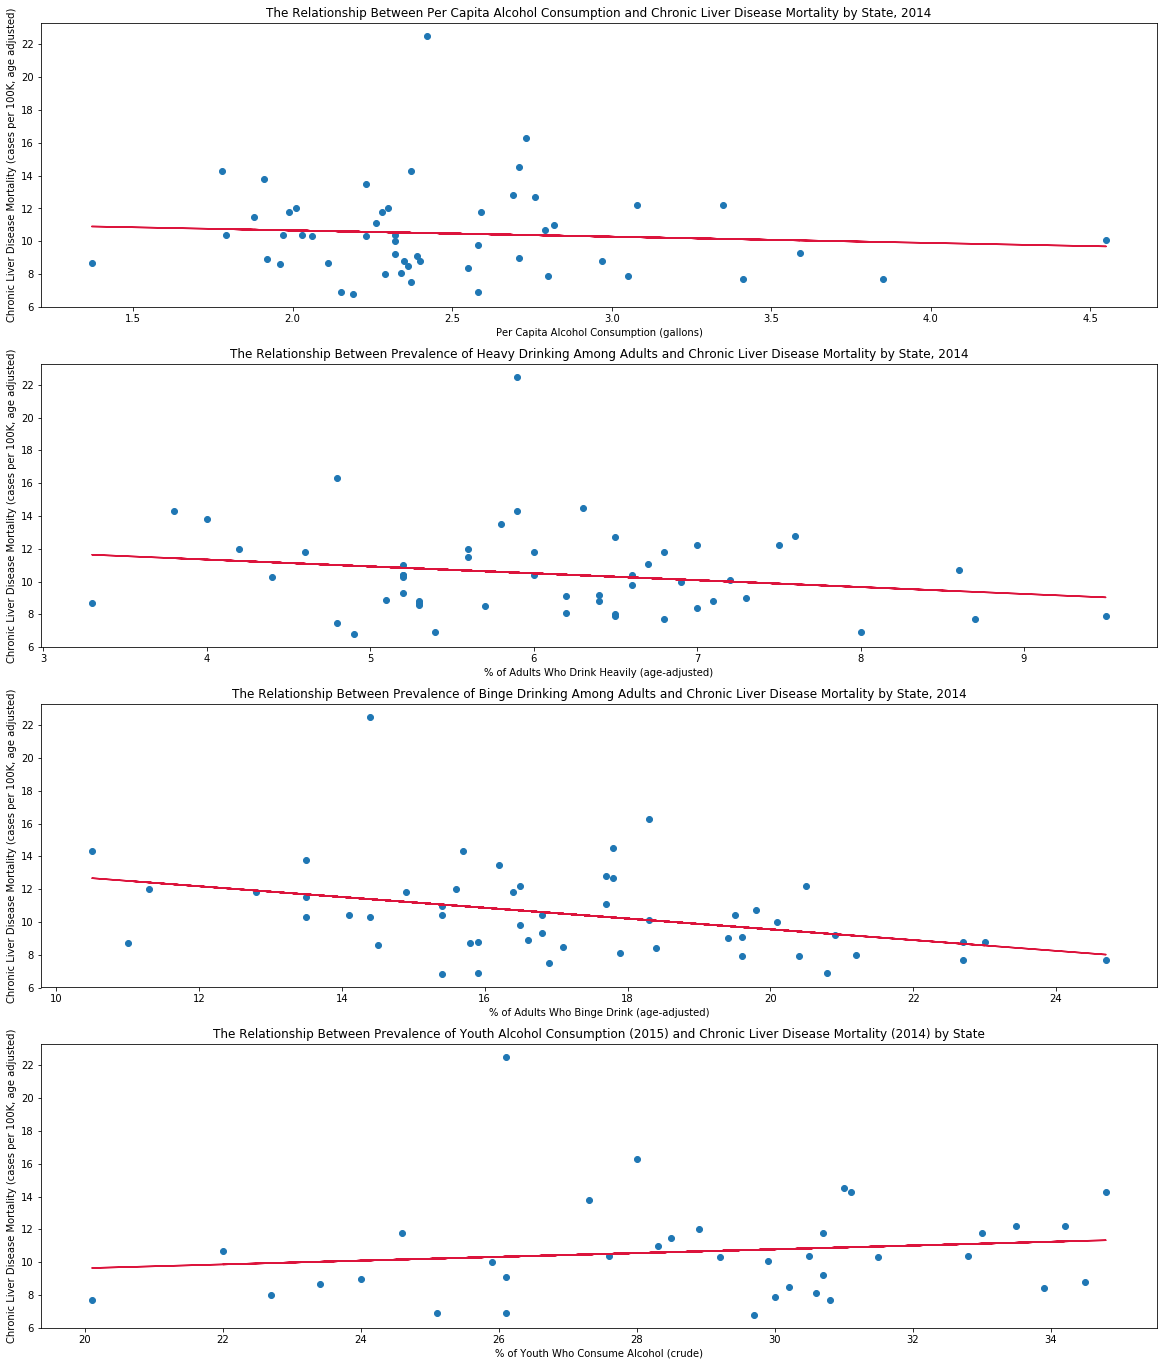

In [222]:
%matplotlib inline

fig, axes = plt.subplots(4,1, figsize=(20,24))

ax1 = axes[0]
ax1.set_ylabel(chrond["ax_label"])
ax1.set_xlabel(dsets["con_ld"]["ax_label"])
ax1.set_title("The Relationship Between Per Capita Alcohol Consumption and Chronic Liver Disease Mortality by State, 2014")
ax1.plot(con_ld.DataValueAlt_y, con_ld.DataValueAlt_x, 'o')
z = np.polyfit(con_ld.DataValueAlt_y, con_ld.DataValueAlt_x, 1)
p = np.poly1d(z)
ax1.plot(con_ld.DataValueAlt_y, p(con_ld.DataValueAlt_y), color="crimson")

ax2 = axes[1]
ax2.set_ylabel(chrond["ax_label"])
ax2.set_xlabel(dsets["heav_ld"]["ax_label"])
ax2.set_title("The Relationship Between Prevalence of Heavy Drinking Among Adults and Chronic Liver Disease Mortality by State, 2014")
ax2.scatter(heav_ld.DataValueAlt_y, heav_ld.DataValueAlt_x)
z = np.polyfit(heav_ld.DataValueAlt_y, heav_ld.DataValueAlt_x, 1)
p = np.poly1d(z)
ax2.plot(heav_ld.DataValueAlt_y, p(heav_ld.DataValueAlt_y), color="crimson")

ax3 = axes[2]
ax3.set_ylabel(chrond["ax_label"])
ax3.set_xlabel(dsets["bng_ld"]["ax_label"])
ax3.set_title("The Relationship Between Prevalence of Binge Drinking Among Adults and Chronic Liver Disease Mortality by State, 2014")
ax3.scatter(bng_ld.DataValueAlt_y, bng_ld.DataValueAlt_x)
z = np.polyfit(bng_ld.DataValueAlt_y, bng_ld.DataValueAlt_x, 1)
p = np.poly1d(z)
ax3.plot(bng_ld.DataValueAlt_y, p(bng_ld.DataValueAlt_y), color="crimson")

ax4 = axes[3]
ax4.set_ylabel(chrond["ax_label"])
ax4.set_xlabel(dsets["yth_ld"]["ax_label"])
ax4.set_title("The Relationship Between Prevalence of Youth Alcohol Consumption (2015) and Chronic Liver Disease Mortality (2014) by State")
ax4.scatter(yth_ld.DataValueAlt_y, yth_ld.DataValueAlt_x)
z = np.polyfit(yth_ld.DataValueAlt_y, yth_ld.DataValueAlt_x, 1)
p = np.poly1d(z)
ax4.plot(yth_ld.DataValueAlt_y, p(yth_ld.DataValueAlt_y), color="crimson")
plt.show()

## The Health Impact of Alcohol Consumption Patterns

The reason that the CDC and other health organizations conduct alcohol-related surveillance studies is because alcohol is a risk factor for a range of morbidities, including chronic liver disease. In order to develop programs that prevent or respond effectively to alcohol-related health risks, it is important to understand which populations are at highest risk. Therefore, I looked at the prevalence of chronic liver disease mortality in relationship to four populations for each US state:
- Total per capita alcohol consumption across individuals 14 years of age and older. As explained above, this is an approximation for the consumption of an average member of the state population.
- Prevalence of adults who drink heavily (age-adjusted);
- Prevalence of adults who binge drink (age-adjusted); and
- Prevalence of youth alcohol consumption (crude).

The results are not particularly illuminating. The only metric that seemed to increase with chronic liver disease mortality was the prevalence of youth who consume alcohol. All the other metrics either displayed no relationship or, counterintuitively, a negative relationship. While it could be the case that youth alcohol consumption is truly the largest alcohol-related driver of chronic liver disease mortality, there were also key methodological limitations that the reader should consider before drawing conclusions: the use of population-level metrics, and the fact that the data represents values from 2014 and 2015. This second limitation is particularly important because alcohol-related chronic liver disease develops only after years of alcohol abuse. Therefore, even assuming that state populations have remained stable over the years, 2014's chronic liver disease mortality trends are the results of over a decade of alcohol consumption trends, which may have changed in the interim.

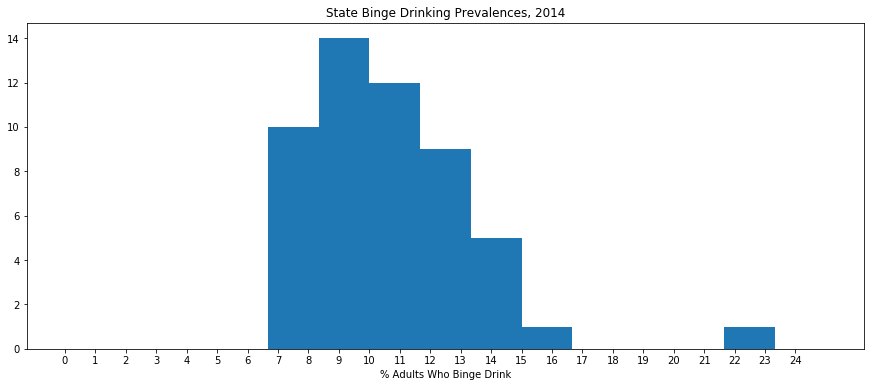

In [210]:
plt.figure(figsize=(15,6))
plt.hist(bng_ld.DataValueAlt_x, bins=15, range=[0,25])
plt.title('State Binge Drinking Prevalences, 2014')
plt.xlabel('% Adults Who Binge Drink')
plt.xticks(np.arange(0, 25, 1))
plt.show()

## State Binge Drinking in Adults in 2014
I wanted to examine binge drinking more closely. This first graph is a histogram of states' binge drinking prevalence among adults aged 18 and older. The data is right-skewed with most state prevalences between 7% and 13%. The highest two prevalences were 22% and 23% of adults. These values have been age-adjusted. 

,Topic,Category,labels
DataValue,,,
Category 1 - State had exclusive local alcohol retail licensing,8,Category 1 - State had exclusive local alcohol...,Category 1 - State had exclusive local alcohol...
Category 2 - State had joint local and state alcohol retail licensing,10,Category 2 - State had joint local and state a...,Category 2 - State had joint local and state a...
Category 3 - State had exclusive state alcohol retail licensing but with local zoning authority,16,Category 3 - State had exclusive state alcohol...,Category 3 - State had exclusive state alcohol...
Category 4 - State had mixed alcohol retail licensing policies,8,Category 4 - State had mixed alcohol retail li...,Category 4 - State had mixed alcohol retail li...
Category 5 - State had nearly exclusive state alcohol retail licensing,2,Category 5 - State had nearly exclusive state ...,Category 5 - State had nearly exclusive state ...
Category 6 - State had exclusive state alcohol retail licensing,6,Category 6 - State had exclusive state alcohol...,Category 6 - State had exclusive state alcohol...
Category 7 - No regulation authority,5,Category 7 - No regulation authority,Category 7 - No regulation authority (n=5)


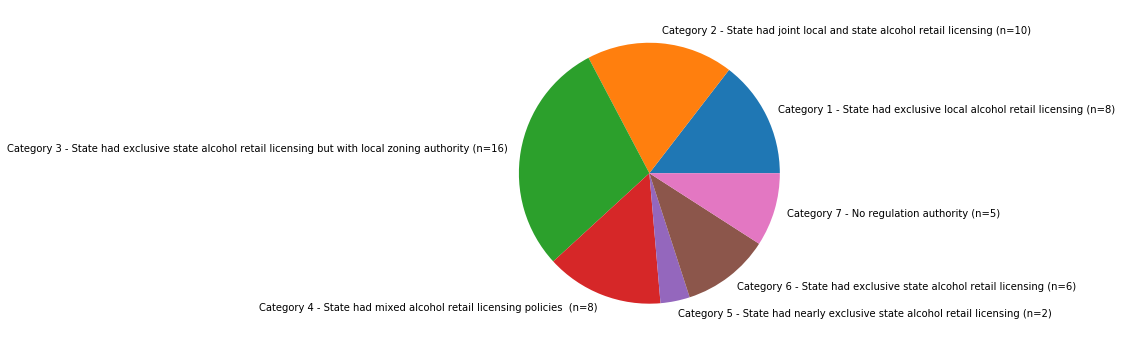

In [275]:
plt.figure(figsize=(15, 6))
plt.pie(auth["Topic"], labels=auth["labels"])
plt.show()

## State Regulation of Alcohol Sales
The final question I wanted to ask was where potential policy levers existed. If alcohol is a risk factor, at what level of government should concerned voters lobby for change? The question in the dataset that came the closest was around licensing and zoning power. Not surprisingly, the majority of states and territories (34) had some kind of joint or mixed model. A particularly interesting case is Category 3, wherein states license alcohol vendors but local government oversees zoning. This means that the state regulates who is allowed to sell alcohol, but local communities dictate when and where retailers are allowed to operate. Also of note is that an equal number of states put licensing exclusively under local jurisdiction as under state jurisdiction (Categories 1, 5, and 6). The takeaway is that populations concerned with alcohol retail patterns in their community may have considerable power to demand change.